In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import requests
import datetime
from matplotlib.lines import Line2D
import matplotlib as mpl
import copy
import math
import pickle

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'get_comm_manager' is not defined

In [11]:
from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

## NOTE: This code uses mechaFIL in a non-standard way. To reproduce the results,
#   the `sdm_take2_analysis` branch of mechaFIL needs to be used - not the main branch.
#   https://github.com/protocol/filecoin-mecha-twin/tree/sdm_take2_analysis
# This comment is relevant as of 3-Jan-2023.

In [12]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2022, 12, 1) 
DATA_LAG_DAYS = 0
current_date = today - datetime.timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 16)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*10)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-16
2022-12-01
2032-11-28


In [13]:
offline_folder = 'offline_info'
results_folder = 'results'
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

In [14]:
fp = os.path.join(offline_folder, 'historical.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    historical_renewal_rate =  z['historical_renewal_rate']
    t_fpr = z['t_fpr']
    historical_fpr = z['historical_fpr']
    fil_stats_df = z['fil_stats_df']
    sector_expiration_stats_offline = z['sector_expiration_stats']
    
    # WARNING: this is a hack b/c we stored historical_renewal_rate from start_date=3/15/2021
    #  but, data starts at 3/16/2021, so this hack ... fix asap so you don't have to
    #  think about this again later ..
    if start_date == datetime.date(2021, 3, 16):
        historical_renewal_rate = historical_renewal_rate[1:]
else:
    _, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    dict_out = {
        'historical_renewal_rate': historical_renewal_rate,
        't_fpr': t_fpr,
        'historical_fpr': historical_fpr,
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats': sector_expiration_stats_offline
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)
        
# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [15]:
# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)


def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    duration_yr = duration/365
    cil_rbp['duration_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    cil_rbp['duration_sector_roi'] = cil_rbp['duration_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['duration_roi_annualized'] = np.power(cil_rbp['duration_sector_roi'] + 1, 1/duration_yr) - 1
    return cil_rbp

def run_sim(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            duration=365, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
#     fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
#     current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN
    }
    
    return return_dict

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

In [16]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - datetime.timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + datetime.timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 5000
num_samples_mcmc = 500
seasonality_mcmc = 5000
num_chains_mcmc = 2

fp = os.path.join(offline_folder, 'mcmc.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    rb_onboard_power_pred = z['rb_onboard_power_pred']
    renewal_rate_pred = z['renewal_rate_pred']
    filplus_rate_pred = z['filplus_rate_pred']
else:
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_lenght,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc)
    dict_out = {
        'rb_onboard_power_pred': np.asarray(rb_onboard_power_pred),
        'renewal_rate_pred': np.asarray(renewal_rate_pred),
        'filplus_rate_pred': np.asarray(filplus_rate_pred),
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)

In [17]:
current_day_stats = fil_stats_df.iloc[-1]
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0

In [18]:
intervention_date=datetime.date(2023,1,15)
duration_m = lambda d: (1 if d <= round(365*1.5) else (d-183)/365)
num_days_shock_behavior = 360

mcmc_scenario = {
    'rb_onboard_power': np.median(np.asarray(rb_onboard_power_pred), axis=0), 
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0)
}

scenario_to_use = copy.deepcopy(mcmc_scenario)
qap_mode = 'basic-sdm'

sim_vec = []
durations_vec_yrs = [1, 2, 3, 4, 5]
for duration_yr in durations_vec_yrs:
    nn_append = '%dY' % (duration_yr,)
    duration_days = duration_yr * 365
    
    no_sdm = {'name': 'No-SDM(%s)' % (nn_append,), 
     'rbp': copy.deepcopy(scenario_to_use['rb_onboard_power']),
     'rr': copy.deepcopy(scenario_to_use['renewal_rate']),
     'fpr': copy.deepcopy(scenario_to_use['filplus_rate']),
     'kwargs':{'duration': duration_days, 'duration_m': lambda d: 1, 'qap_mode':qap_mode,
               'intervention_config': {
                   'type': 'noop',
                   'num_days_shock_behavior': num_days_shock_behavior,
                   'intervention_date': intervention_date,
                   'simulation_start_date': current_date + datetime.timedelta(days=1),
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': False,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    }
    
    scenario_1a = {'name': '1A(%s)' % (nn_append,),  
     'rbp': copy.deepcopy(scenario_to_use['rb_onboard_power']),
     'rr': copy.deepcopy(scenario_to_use['renewal_rate']),
     'fpr': copy.deepcopy(scenario_to_use['filplus_rate']),
     'kwargs':{'duration': duration_days, 'duration_m': duration_m, 'qap_mode':qap_mode,
               'intervention_config': {
                   'type': 'noop',
                   'num_days_shock_behavior': num_days_shock_behavior,
                   'intervention_date': intervention_date,
                   'simulation_start_date': current_date + datetime.timedelta(days=1),
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': True
               }
              }
    }
    scenario_1b = {'name': '1B(%s)' % (nn_append,),  
     'rbp': copy.deepcopy(scenario_to_use['rb_onboard_power']),
     'rr': copy.deepcopy(scenario_to_use['renewal_rate']),
     'fpr': copy.deepcopy(scenario_to_use['filplus_rate']),
     'kwargs':{'duration': duration_days, 'duration_m': duration_m, 'qap_mode':qap_mode,
               'intervention_config': {
                   'type': 'cc_early_renewal',
                   'num_days_shock_behavior': num_days_shock_behavior,
                   'intervention_date': intervention_date,
                   'simulation_start_date': current_date + datetime.timedelta(days=1),
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': True
               }
              }
    }
    scenario_2a = {'name': '2A(%s)' % (nn_append,),
     'rbp': copy.deepcopy(scenario_to_use['rb_onboard_power']),
     'rr': copy.deepcopy(scenario_to_use['renewal_rate']),
     'fpr': copy.deepcopy(scenario_to_use['filplus_rate']),
     'kwargs':{'duration': duration_days, 'duration_m': duration_m, 'qap_mode':qap_mode,
               'intervention_config': {
                   'type': 'noop',
                   'num_days_shock_behavior': num_days_shock_behavior,
                   'intervention_date': intervention_date,
                   'simulation_start_date': current_date + datetime.timedelta(days=1),
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    }
    scenario_2b = {'name': '2B(%s)' % (nn_append,),
     'rbp': copy.deepcopy(scenario_to_use['rb_onboard_power']),
     'rr': copy.deepcopy(scenario_to_use['renewal_rate']),
     'fpr': copy.deepcopy(scenario_to_use['filplus_rate']),
     'kwargs':{'duration': duration_days, 'duration_m': duration_m, 'qap_mode':qap_mode,
               'intervention_config': {
                   'type': 'cc_early_terminate_and_onboard',
                   'num_days_shock_behavior': num_days_shock_behavior,
                   'cc_reonboard_time_days': 60,
                   'intervention_date': intervention_date,
                   'simulation_start_date': current_date + datetime.timedelta(days=1),
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    }
    sim_vec.append(copy.deepcopy(no_sdm))
    sim_vec.append(copy.deepcopy(scenario_1a))
    sim_vec.append(copy.deepcopy(scenario_1b))
    sim_vec.append(copy.deepcopy(scenario_2a))
    sim_vec.append(copy.deepcopy(scenario_2b))

In [10]:
duration_loop_results = {}
for sim in tqdm(sim_vec):
    kwargs = sim['kwargs']
    return_dict = run_sim(sim['rbp'], sim['rr'], sim['fpr'], **kwargs)
    duration_loop_results[sim['name']] = return_dict

  0%|          | 0/25 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


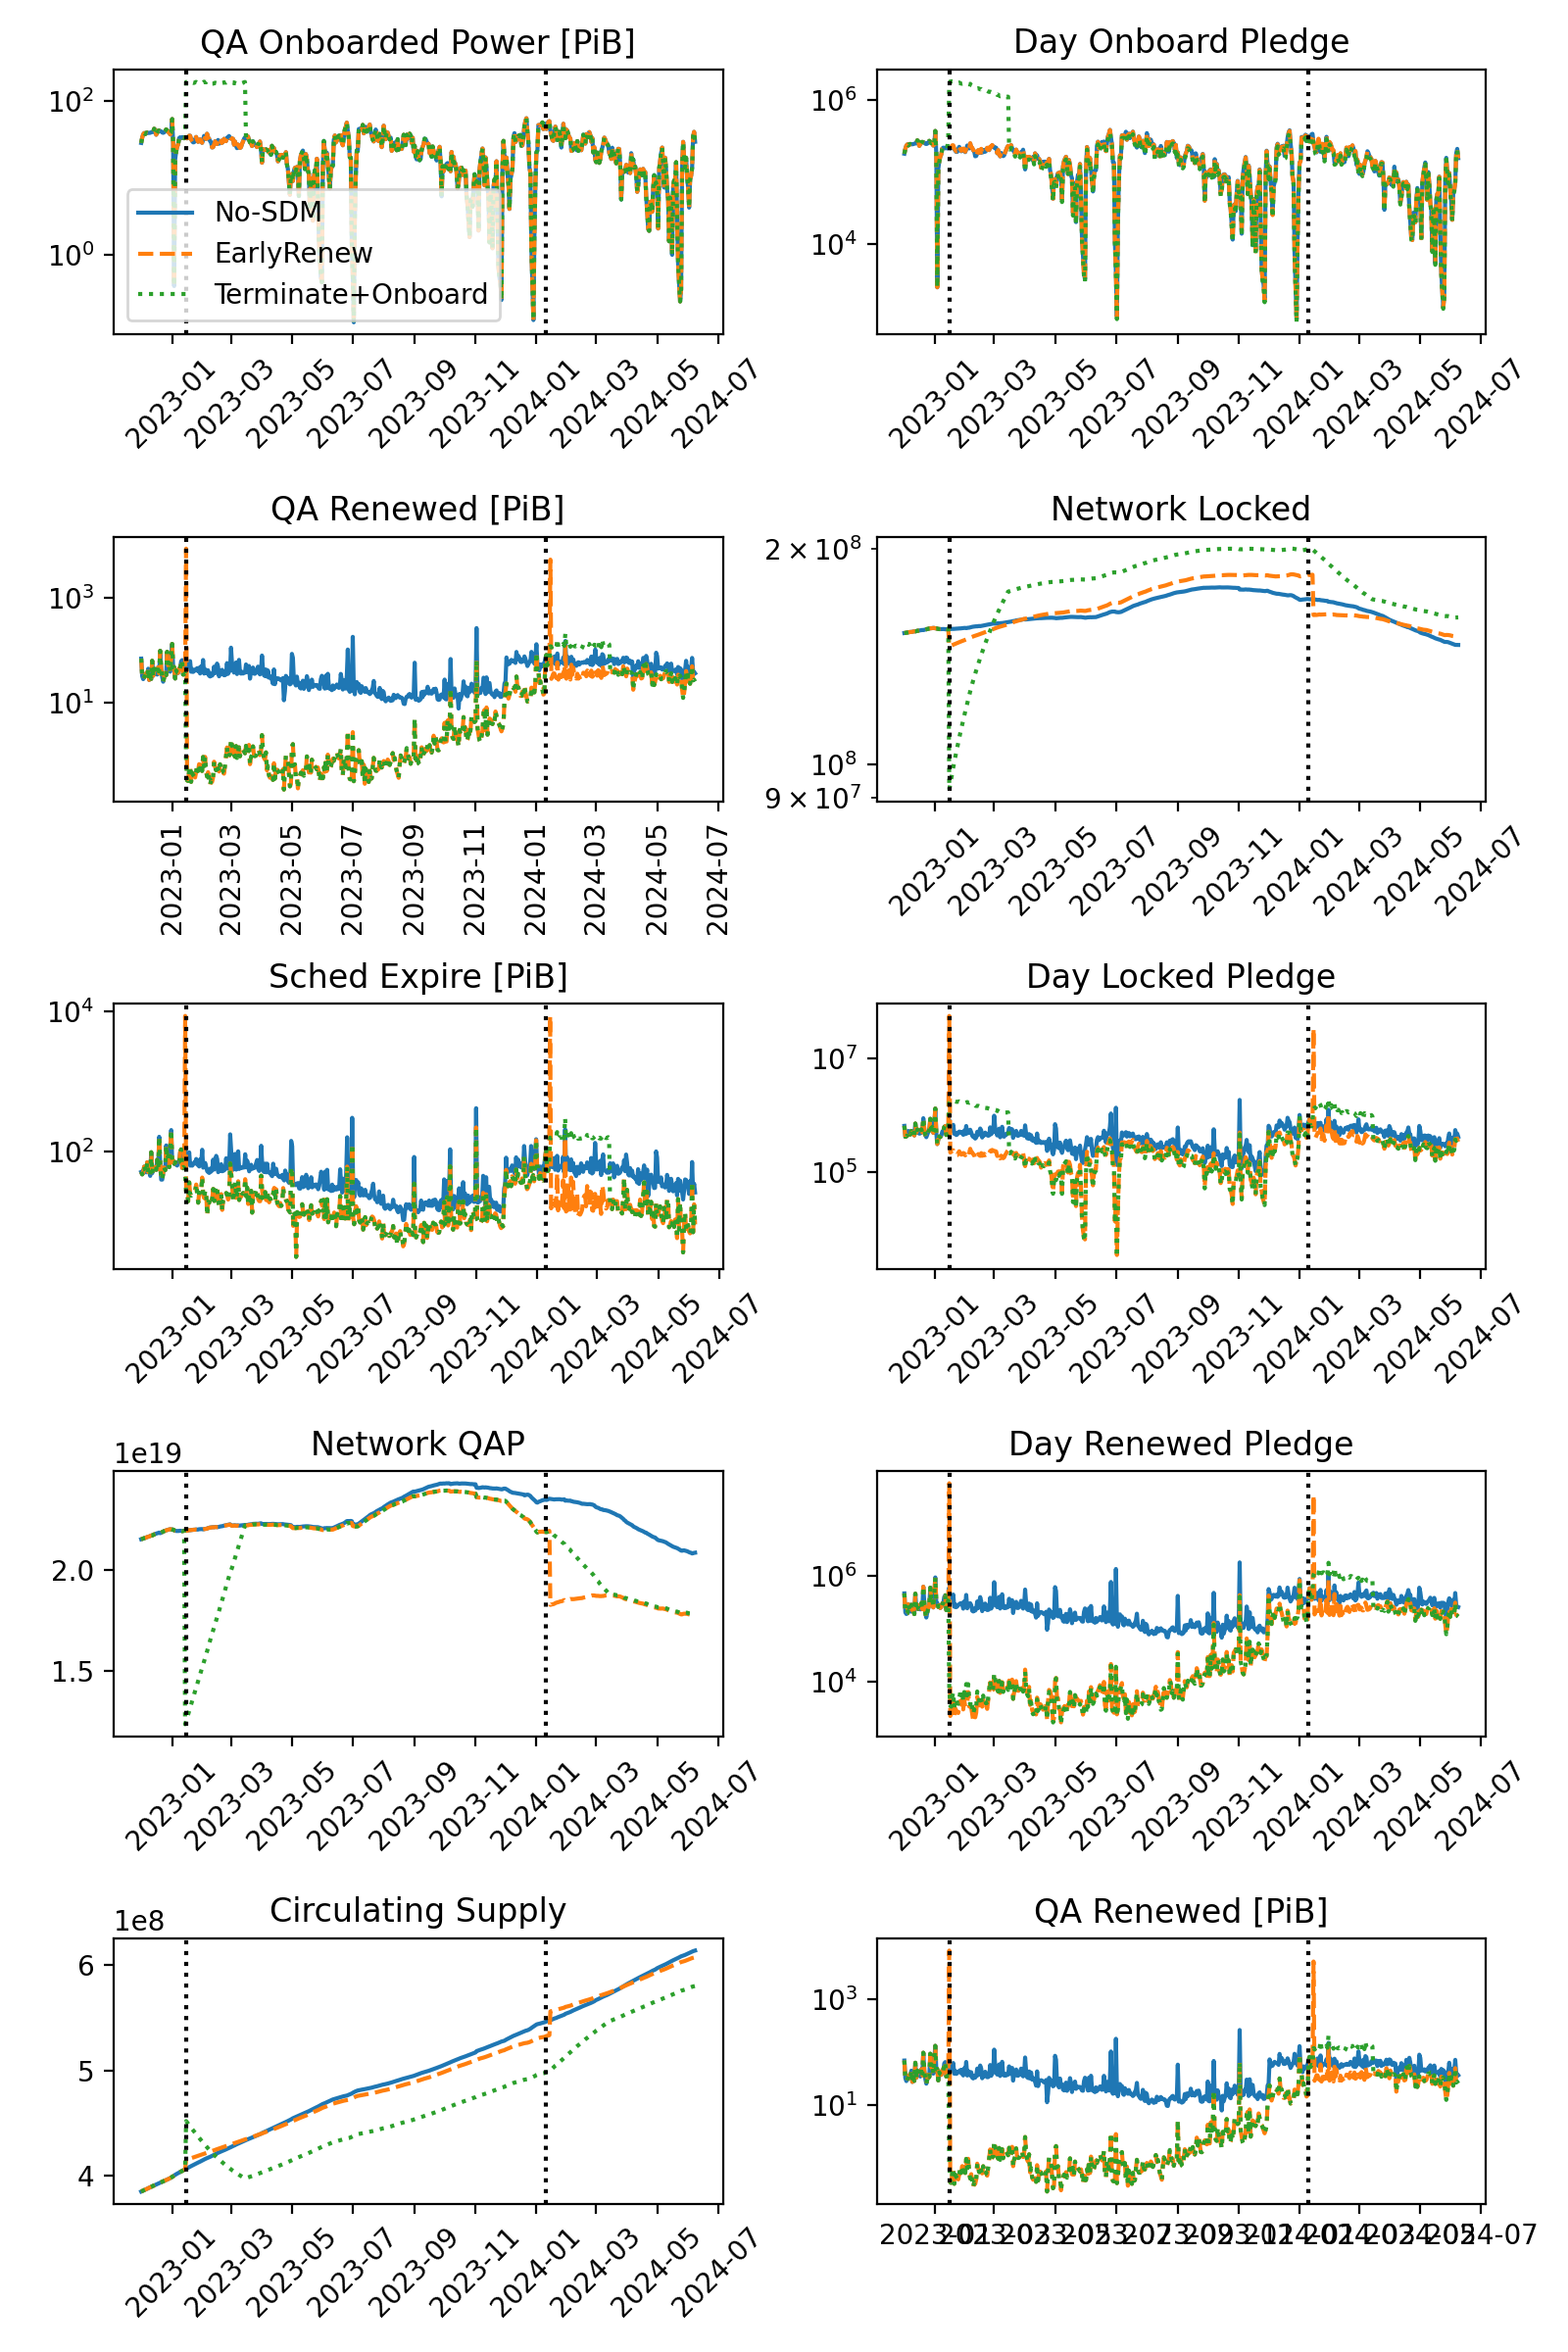

In [11]:
plt_yr = 1
power_debug = False
cs_debug = True

plt_earlyrenew = True
plt_terminate = True

no_sdm_p_df = duration_loop_results['No-SDM(%dY)' % (plt_yr,)]['power_df']
no_sdm_rbp_df = duration_loop_results['No-SDM(%dY)' % (plt_yr,)]['rb_power_df']
no_sdm_qap_df = duration_loop_results['No-SDM(%dY)' % (plt_yr,)]['qa_power_df']
no_sdm_df = duration_loop_results['No-SDM(%dY)' % (plt_yr,)]['rbp_roi']

r1b_p_df = duration_loop_results['1B(%dY)' % (plt_yr,)]['power_df']
r1b_rbp_df = duration_loop_results['1B(%dY)' % (plt_yr,)]['rb_power_df']
r1b_qap_df = duration_loop_results['1B(%dY)' % (plt_yr,)]['qa_power_df']
r1b_df = duration_loop_results['1B(%dY)' % (plt_yr,)]['rbp_roi']

r2b_p_df = duration_loop_results['2B(%dY)' % (plt_yr,)]['power_df']
r2b_rbp_df = duration_loop_results['2B(%dY)' % (plt_yr,)]['rb_power_df']
r2b_qap_df = duration_loop_results['2B(%dY)' % (plt_yr,)]['qa_power_df']
r2b_df = duration_loop_results['2B(%dY)' % (plt_yr,)]['rbp_roi']

t = [today + datetime.timedelta(days=x) for x in range(forecast_lenght)]
intervention_day = (intervention_date - today).days

dd_neg=45
dd_pos=150

no_sdm_p_df_window = no_sdm_p_df[(no_sdm_p_df['date'] >= (intervention_date-datetime.timedelta(days=dd_neg))) & (no_sdm_p_df['date'] <= (intervention_date+datetime.timedelta(days=360+dd_pos)))]
r1b_p_df_window = r1b_p_df[(no_sdm_p_df['date'] >= (intervention_date-datetime.timedelta(days=dd_neg))) & (r1b_p_df['date'] <= (intervention_date+datetime.timedelta(days=360+dd_pos)))]
no_sdm_rbp_df_window = no_sdm_rbp_df.iloc[intervention_day-dd_neg:intervention_day+360+dd_pos]
r1b_rbp_df_window = r1b_rbp_df.iloc[intervention_day-dd_neg:intervention_day+360+dd_pos]
no_sdm_qap_df_window = no_sdm_qap_df.iloc[intervention_day-dd_neg:intervention_day+360+dd_pos]
r1b_qap_df_window = r1b_qap_df.iloc[intervention_day-dd_neg:intervention_day+360+dd_pos]
no_sdm_df_window = no_sdm_df[(no_sdm_df['date'] >= (intervention_date-datetime.timedelta(days=dd_neg))) & (no_sdm_df['date'] <= (intervention_date+datetime.timedelta(days=360+dd_pos)))]
r1b_df_window = r1b_df[(r1b_df['date'] >= (intervention_date-datetime.timedelta(days=dd_neg))) & (r1b_df['date'] <= (intervention_date+datetime.timedelta(days=360+dd_pos)))]

r2b_p_df_window = r2b_p_df[(no_sdm_p_df['date'] >= (intervention_date-datetime.timedelta(days=dd_neg))) & (r2b_p_df['date'] <= (intervention_date+datetime.timedelta(days=360+dd_pos)))]
r2b_rbp_df_window = r2b_rbp_df.iloc[intervention_day-dd_neg:intervention_day+360+dd_pos]
r2b_qap_df_window = r2b_qap_df.iloc[intervention_day-dd_neg:intervention_day+360+dd_pos]
r2b_df_window = r2b_df[(r2b_df['date'] >= (intervention_date-datetime.timedelta(days=dd_neg))) & (r2b_df['date'] <= (intervention_date+datetime.timedelta(days=360+dd_pos)))]

t_window = t[intervention_day-dd_neg:intervention_day+360+dd_pos]

plt.figure(figsize=(8,12))
plt.subplot(5,2,1)
if power_debug:
    plt.plot(t_window, no_sdm_rbp_df_window['onboarded_power'], label='No-SDM')
    if plt_earlyrenew:
        plt.plot(t_window, r1b_rbp_df_window['onboarded_power'], label='EarlyRenew', linestyle='--')
    if plt_terminate:
        plt.plot(t_window, r2b_rbp_df_window['onboarded_power'], label='Terminate+Onboard', linestyle=':')
    plt.yscale('log')
    plt.title('RB Onboarded Power [PiB]')
else:
    plt.plot(no_sdm_p_df_window['date'], no_sdm_p_df_window['day_onboarded_qa_power_pib'], label='No-SDM')
    if plt_earlyrenew:
        plt.plot(r1b_p_df_window['date'], r1b_p_df_window['day_onboarded_qa_power_pib'], label='EarlyRenew', linestyle='--')
    if plt_terminate:
        plt.plot(r1b_p_df_window['date'], r2b_p_df_window['day_onboarded_qa_power_pib'], label='Terminate+Onboard', linestyle=':')
    plt.title('QA Onboarded Power [PiB]')
    plt.yscale('log')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')

plt.xticks(rotation=45)
plt.legend()
plt.subplot(5,2,2)
if power_debug:
    plt.plot(t_window, no_sdm_rbp_df_window['cum_onboarded_power'])
    if plt_earlyrenew:
        plt.plot(t_window, r1b_rbp_df_window['cum_onboarded_power'], linestyle='--')
    if plt_terminate:
        plt.plot(t_window, r2b_rbp_df_window['cum_onboarded_power'])
    plt.title('RB Onboarded power [CumSum]')
elif cs_debug:
    plt.plot(no_sdm_df_window['date'], no_sdm_df_window['day_onboard_pledge'])
    if plt_earlyrenew:
        plt.plot(r1b_df_window['date'], r1b_df_window['day_onboard_pledge'], linestyle='--')
    if plt_terminate:
        plt.plot(r2b_df_window['date'], r2b_df_window['day_onboard_pledge'], linestyle=':')
    plt.title('Day Onboard Pledge')
    plt.yscale('log')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')
plt.xticks(rotation=45)

plt.subplot(5,2,3)
if power_debug:
    plt.plot(t_window, no_sdm_rbp_df_window['renewed_power'])
    if plt_earlyrenew:
        plt.plot(t_window, r1b_rbp_df_window['renewed_power'], linestyle='--')
    if plt_terminate:
        plt.plot(t_window, r2b_rbp_df_window['renewed_power'], linestyle=':')
    plt.title('RB Renewed [PiB]')
elif cs_debug:
    plt.plot(no_sdm_df_window['date'], no_sdm_df_window['day_renewed_power_QAP']/2**50)
    if plt_earlyrenew:
        plt.plot(r1b_df_window['date'], r1b_df_window['day_renewed_power_QAP']/2**50, linestyle='--')
    if plt_terminate:
        plt.plot(r2b_df_window['date'], r2b_df_window['day_renewed_power_QAP']/2**50, linestyle=':')
    plt.title('QA Renewed [PiB]')
    
plt.yscale('log')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')
plt.xticks(rotation=90)

plt.subplot(5,2,4)
if power_debug:
    plt.plot(t_window, no_sdm_rbp_df_window['cum_renewed_power'])
    if plt_earlyrenew:
        plt.plot(t_window, r1b_rbp_df_window['cum_renewed_power'])
    if plt_terminate:
        plt.plot(t_window, r2b_rbp_df_window['cum_renewed_power'])
    plt.title('Renewed [CumSum]')
elif cs_debug:
    plt.plot(no_sdm_df_window['date'], no_sdm_df_window['network_locked'])
    if plt_earlyrenew:
        plt.plot(r1b_df_window['date'], r1b_df_window['network_locked'], linestyle='--')
    if plt_terminate:
        plt.plot(r2b_df_window['date'], r2b_df_window['network_locked'], linestyle=':')
    plt.title('Network Locked')
    plt.yscale('log')

plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')

plt.xticks(rotation=45)

plt.subplot(5,2,5)
plt.plot(t_window, no_sdm_rbp_df_window['expire_scheduled_power'])
if plt_earlyrenew:
    plt.plot(t_window, r1b_rbp_df_window['expire_scheduled_power'], linestyle='--')
if plt_terminate:
    plt.plot(t_window, r2b_rbp_df_window['expire_scheduled_power'], linestyle=':')
plt.yscale('log')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')
plt.title('Sched Expire [PiB]')
plt.xticks(rotation=45)

plt.subplot(5,2,6)
if power_debug:
    plt.plot(t_window, no_sdm_rbp_df_window['cum_expire_scheduled_power'])
    if plt_earlyrenew:
        plt.plot(t_window, r1b_rbp_df_window['cum_expire_scheduled_power'], linestyle='--')
    if plt_terminate:
        plt.plot(t_window, r2b_rbp_df_window['cum_expire_scheduled_power'], linestyle=':')
    plt.title('Sched Expire [CumSum]')
elif cs_debug:
    plt.plot(no_sdm_df_window['date'], no_sdm_df_window['day_locked_pledge'])
    if plt_earlyrenew:
        plt.plot(r1b_df_window['date'], r1b_df_window['day_locked_pledge'], linestyle='--')
    if plt_terminate:
        plt.plot(r2b_df_window['date'], r2b_df_window['day_locked_pledge'], linestyle=':')
    plt.title('Day Locked Pledge')
    plt.yscale('log')
# plt.yscale('log')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')

plt.xticks(rotation=45)

plt.subplot(5,2,7)
if power_debug:
    y1 = no_sdm_rbp_df_window['onboarded_power'] + no_sdm_rbp_df_window['renewed_power'] - no_sdm_rbp_df_window['expire_scheduled_power']
    plt.plot(t_window, y1)
    if plt_earlyrenew:
        y2 = r1b_rbp_df_window['onboarded_power'] + r1b_rbp_df_window['renewed_power'] - r1b_rbp_df_window['expire_scheduled_power']
        plt.plot(t_window, y2, linestyle=':')
    if plt_terminate:
        y3 = r2b_rbp_df_window['onboarded_power'] + r2b_rbp_df_window['renewed_power'] - r2b_rbp_df_window['expire_scheduled_power']
        plt.plot(t_window, y3, linestyle=':')
    plt.title('RBP [instantaneous]')
    plt.ylim(-50, 50)
elif cs_debug:
    plt.plot(no_sdm_df_window['date'], no_sdm_df_window['network_QAP'])
    if plt_earlyrenew:
        plt.plot(r1b_df_window['date'], r1b_df_window['network_QAP'], linestyle='--')
    if plt_terminate:
        plt.plot(r2b_df_window['date'], r2b_df_window['network_QAP'], linestyle=':')
    plt.title('Network QAP')
plt.xticks(rotation=45)
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')


plt.subplot(5,2,8)
if power_debug:
    yy = rb_power_zero + no_sdm_rbp_df_window['cum_onboarded_power'] + no_sdm_rbp_df_window['cum_renewed_power'] - no_sdm_rbp_df_window['cum_expire_scheduled_power']
    plt.plot(t_window, yy/1024)
    if plt_earlyrenew:
        yy = rb_power_zero + r1b_rbp_df_window['cum_onboarded_power'] + r1b_rbp_df_window['cum_renewed_power'] - r1b_rbp_df_window['cum_expire_scheduled_power']
        plt.plot(t_window, yy/1024, linestyle='--')
    if plt_terminate:
        plt.plot(t_window, r2b_rbp_df_window['total_power']/1024, linestyle=':')
    plt.title('RBP [Manual, CumSum]')
elif cs_debug:
    plt.plot(no_sdm_df_window['date'], no_sdm_df_window['day_renewed_pledge'])
    if plt_earlyrenew:
        plt.plot(r1b_df_window['date'], r1b_df_window['day_renewed_pledge'], linestyle='--')
    if plt_terminate:
        plt.plot(r2b_df_window['date'], r2b_df_window['day_renewed_pledge'], linestyle=':')
    plt.title('Day Renewed Pledge')
    plt.yscale('log')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')
plt.xticks(rotation=45)

plt.subplot(5,2,9)
plt.plot(no_sdm_df_window['date'], no_sdm_df_window['circ_supply'])
if plt_earlyrenew:
    plt.plot(r1b_df_window['date'], r1b_df_window['circ_supply'], linestyle='--')
if plt_terminate:
    plt.plot(r2b_df_window['date'], r2b_df_window['circ_supply'], linestyle=':')
plt.title('Circulating Supply')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')
plt.xticks(rotation=45)

plt.subplot(5,2,10)
plt.plot(no_sdm_df_window['date'], no_sdm_df_window['day_renewed_power_QAP']/2**50)
if plt_earlyrenew:
    plt.plot(r1b_df_window['date'], r1b_df_window['day_renewed_power_QAP']/2**50, linestyle='--')
if plt_terminate:
    plt.plot(r2b_df_window['date'], r2b_df_window['day_renewed_power_QAP']/2**50, linestyle=':')
plt.title('QA Renewed [PiB]')
plt.yscale('log')
plt.axvline(intervention_date, color='k', linestyle=':')
plt.axvline(intervention_date + datetime.timedelta(days=360), color='k', linestyle=':')

plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'detailed_view_%dY.png' % (plt_yr, )))

<IPython.core.display.Javascript object>


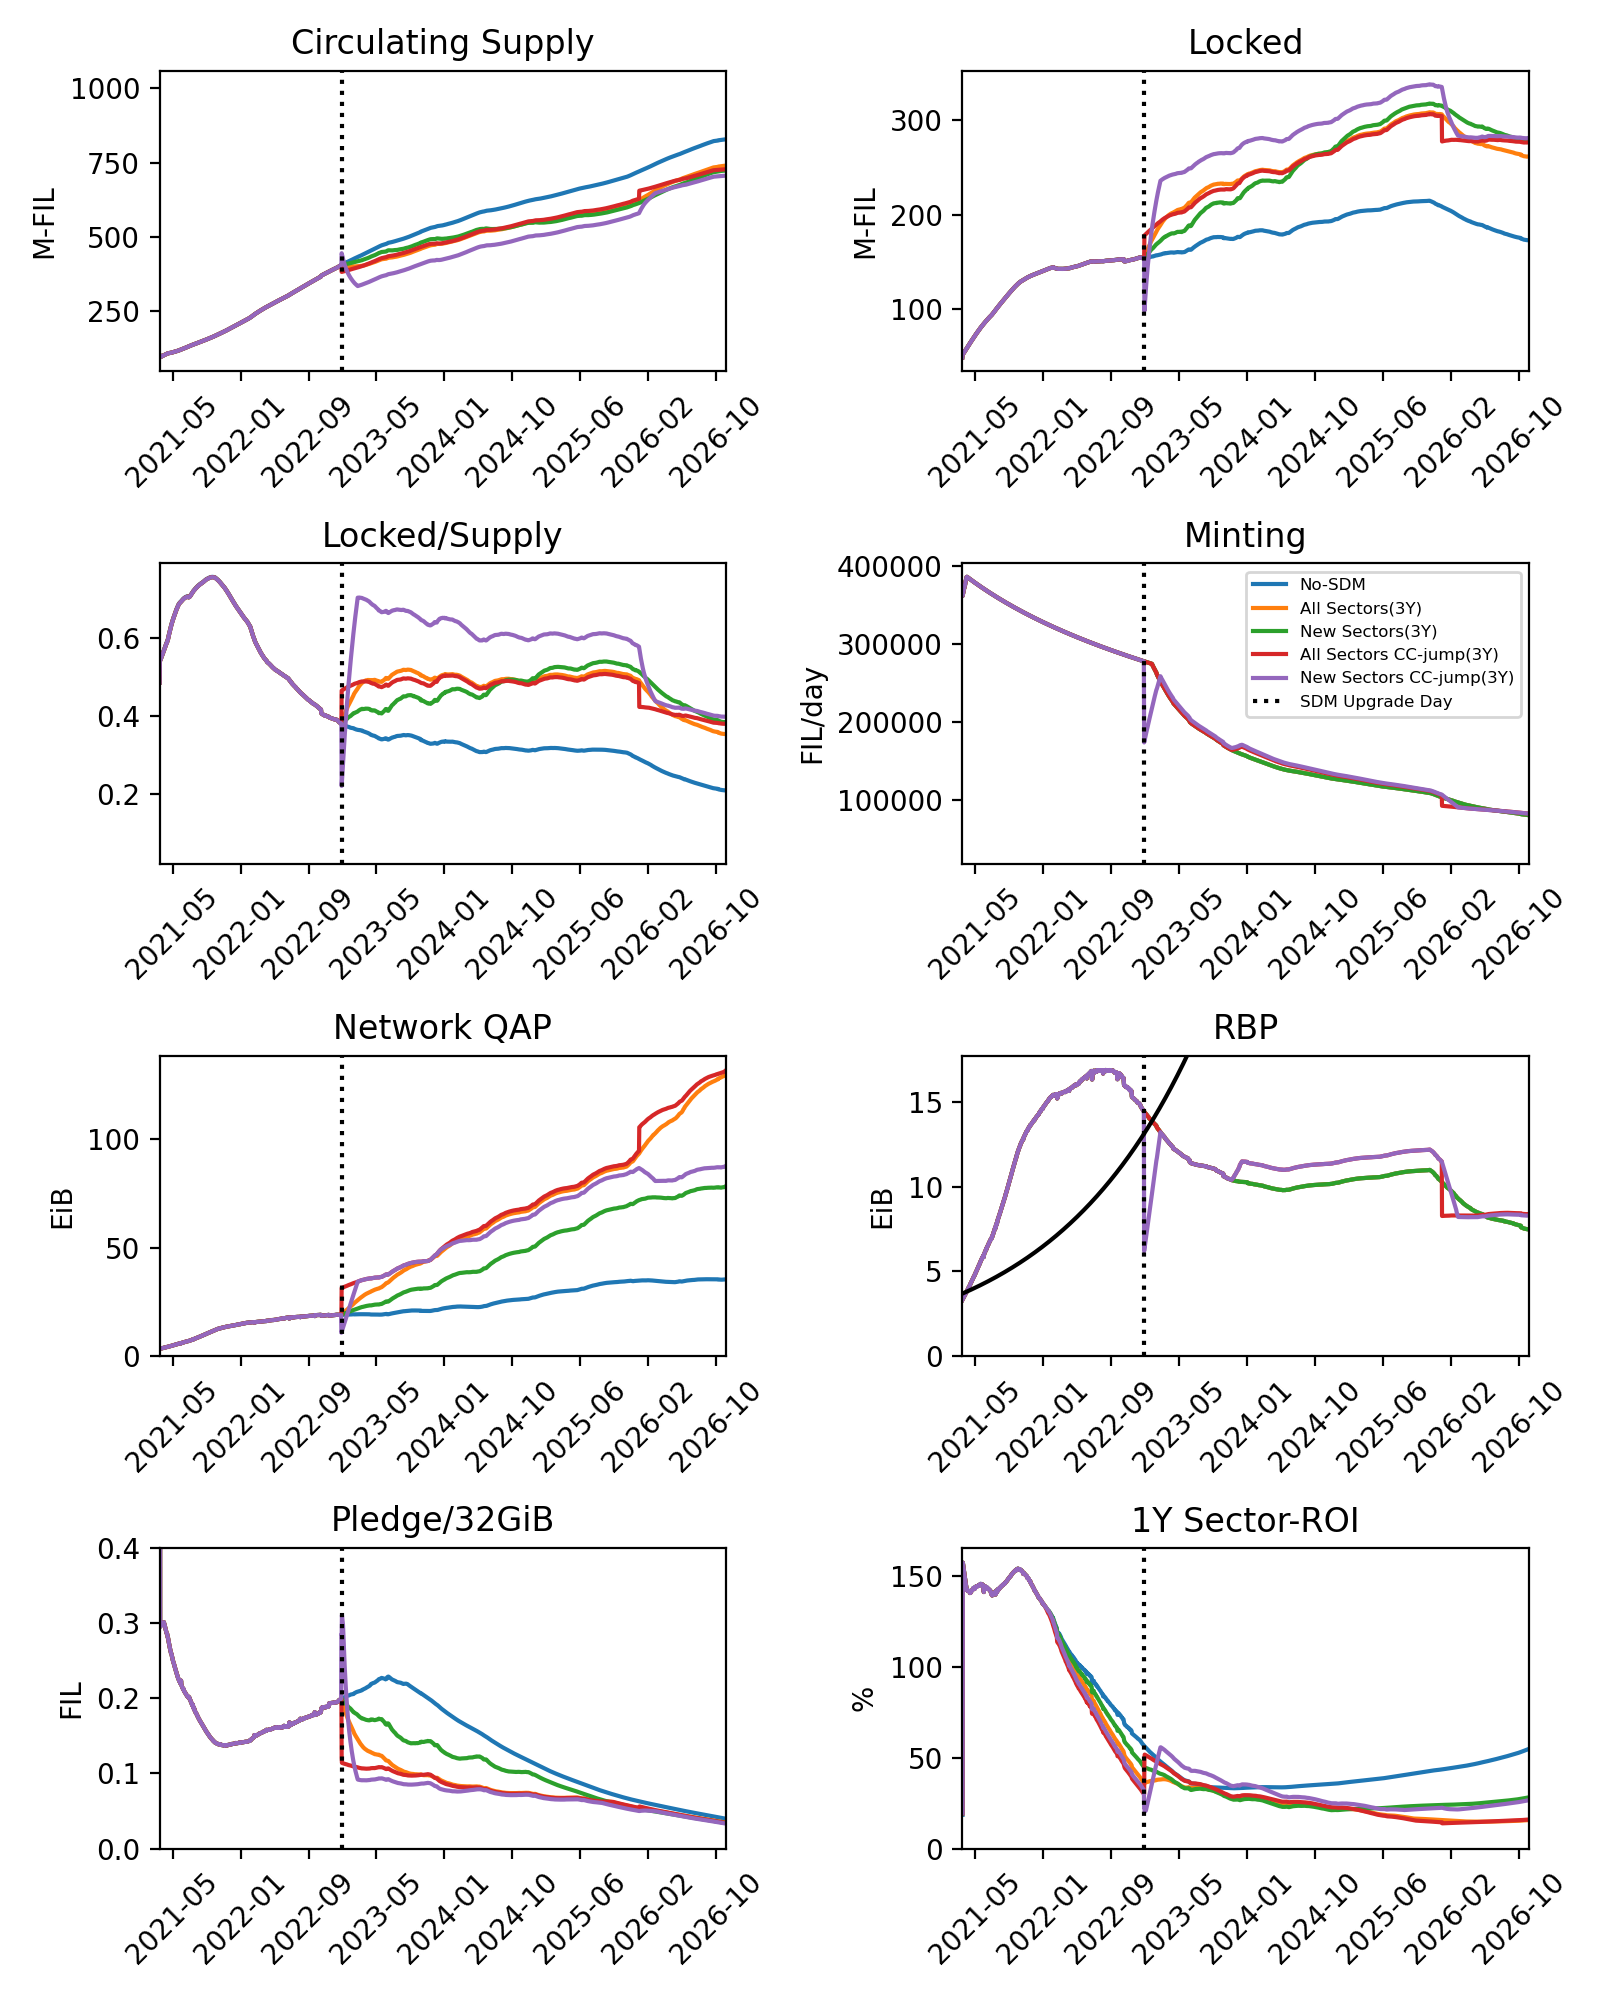

In [12]:
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

plt_sdm = True
plt_a = True
plt_b = True
plt_yr = 3

plt.figure(figsize=(8,10))
if plt_sdm:
    no_sdm = duration_loop_results['No-SDM(%dY)' % (plt_yr,)]['rbp_roi']
if plt_a:
    r1a = duration_loop_results['1A(%dY)' % (plt_yr,)]['rbp_roi']
    r2a = duration_loop_results['2A(%dY)' % (plt_yr,)]['rbp_roi']
if plt_b:
    r1b = duration_loop_results['1B(%dY)' % (plt_yr,)]['rbp_roi']
    r2b = duration_loop_results['2B(%dY)' % (plt_yr,)]['rbp_roi']
        
min_time = no_sdm['date'].iloc[0]
max_time = current_date + datetime.timedelta(days=365*4)
        
plt.subplot(4,2,1)
if plt_sdm:
    p0, = plt.plot(no_sdm['date'], no_sdm['circ_supply'] / MEGA, label='No-SDM')
if plt_a:
    p1, = plt.plot(r1a['date'], r1a['circ_supply'] / MEGA, label='All Sectors(%dY)' % (plt_yr, ))
    p2, = plt.plot(r2a['date'], r2a['circ_supply'] / MEGA, label='New Sectors(%dY)' % (plt_yr, ))
if plt_b:
    p3, = plt.plot(r1b['date'], r1b['circ_supply'] / MEGA, label='All Sectors CC-jump(%dY)' % (plt_yr, ))
    p4, = plt.plot(r2b['date'], r2b['circ_supply'] / MEGA, label='New Sectors CC-jump(%dY)' % (plt_yr, ))

p5 = plt.axvline(intervention_date, linestyle=':', color='k', label='SDM Upgrade Day')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.ylabel('M-FIL')
plt.title('Circulating Supply')
# plt.legend(fontsize=6)
# plt.rc('legend', fontsize = 7)
# l1 = plt.legend([p0,p1,p2], ["No-SDM", "AllSectors", "NewSectors"], loc=0)
# l2 = plt.legend([p3,p4,p5], ["All Sectors CC-jump", "New Sectors CC-jump", "SDM Upgrade Day"], loc=4)
# plt.gca().add_artist(l1)

ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)


plt.subplot(4,2,2)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['network_locked']/MEGA, label='No-SDM')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a['network_locked']/MEGA)
    p2 = plt.plot(r2a['date'], r2a['network_locked']/MEGA)
if plt_b:
    p1 = plt.plot(r1b['date'], r1b['network_locked']/MEGA)
    p2 = plt.plot(r2b['date'], r2b['network_locked']/MEGA)
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Locked')
plt.ylabel('M-FIL')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(4,2,3)
if plt_sdm:
    plt.plot(no_sdm['date'], (no_sdm['network_locked']/no_sdm['circ_supply']), label='No-SDM')
if plt_a:
    p1 = plt.plot(r1a['date'], (r1a['network_locked']/r1a['circ_supply']))
    p2 = plt.plot(r2a['date'], (r2a['network_locked']/r2a['circ_supply']))
if plt_b:
    p1 = plt.plot(r1b['date'], (r1b['network_locked']/r1b['circ_supply']))
    p2 = plt.plot(r2b['date'], (r2b['network_locked']/r2b['circ_supply']))
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Locked/Supply')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

k = 'day_network_reward'; scale=1; ylab_str='FIL/day'; title_str='Minting'
plt.subplot(4,2,4)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm[k]/scale, label='No-SDM')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a[k]/scale, label='All Sectors(%dY)' % (plt_yr, ))
    p2 = plt.plot(r2a['date'], r2a[k]/scale, label='New Sectors(%dY)' % (plt_yr, ))
if plt_b:
    p1 = plt.plot(r1b['date'], r1b[k]/scale, label='All Sectors CC-jump(%dY)' % (plt_yr, ))
    p2 = plt.plot(r2b['date'], r2b[k]/scale, label='New Sectors CC-jump(%dY)' % (plt_yr, ))
plt.axvline(intervention_date, linestyle=':', color='k', label='SDM Upgrade Day')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title(title_str)
plt.ylabel(ylab_str)
plt.legend(fontsize=6)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(4,2,5)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['network_QAP'] / EIB, label='No-SDM')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a['network_QAP']/EIB, label='All Sectors(%dY)' % (plt_yr, ))
    p2 = plt.plot(r2a['date'], r2a['network_QAP']/EIB, label='New Sectors(%dY)' % (plt_yr, ))
if plt_b:
    p1 = plt.plot(r1b['date'], r1b['network_QAP']/EIB, label='All Sectors CC-jump(%dY)' % (plt_yr, ))
    p2 = plt.plot(r2b['date'], r2b['network_QAP']/EIB, label='New Sectors CC-jump(%dY)' % (plt_yr, ))
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Network QAP')
plt.ylabel('EiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_qap = np.max([no_sdm[no_sdm['date']<=max_time]['network_QAP'],
                  r1a[r1a['date']<=max_time]['network_QAP'],
                  r2a[r2a['date']<=max_time]['network_QAP'],
                  r1b[r1b['date']<=max_time]['network_QAP'],
                  r2b[r2b['date']<=max_time]['network_QAP']])
max_qap_eib = max_qap / EIB
plt.ylim(0, max_qap_eib*1.05)
# plt.legend(fontsize=8)


k = 'network_RBP'; title_str='RBP'; scale=EIB; ylab_str = 'EiB'
plt.subplot(4,2,6)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm[k]/scale, label='No-SDM')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a[k]/scale)
    p2 = plt.plot(r2a['date'], r2a[k]/scale)
if plt_b:
    p1 = plt.plot(r1b['date'], r1b[k]/scale)
    p2 = plt.plot(r2b['date'], r2b[k]/scale)
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')

plt.title(title_str)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time][k].values,
                r1a[r1a['date']<=max_time][k].values,
                r2a[r2a['date']<=max_time][k].values,
                r1b[r1b['date']<=max_time][k].values,
                r2b[r2b['date']<=max_time][k].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, mv*1.05/scale)
plt.ylabel(ylab_str)

baseline = baseline_storage(no_sdm.days * EPOCH_PER_DAY)
plt.plot(no_sdm['date'], baseline, color='k')

plt.subplot(4,2,7)
k='day_pledge_per_QAP'
if plt_sdm:
    plt.plot(no_sdm['date'].iloc[1:], no_sdm[k].iloc[1:], label='No-SDM')
if plt_a:
    p1 = plt.plot(r1a['date'].iloc[1:], r1a[k].iloc[1:])
    p2 = plt.plot(r2a['date'].iloc[1:], r2a[k].iloc[1:])
if plt_b:
    p1 = plt.plot(r1b['date'].iloc[1:], r1b[k].iloc[1:])
    p2 = plt.plot(r2b['date'].iloc[1:], r2b[k].iloc[1:])

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Pledge/32GiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time][k].values,
                r1a[r1a['date']<=max_time][k].values,
                r2a[r2a['date']<=max_time][k].values,
                r1b[r1b['date']<=max_time][k].values,
                r2b[r2b['date']<=max_time][k].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, 0.4)
plt.ylabel('FIL')

plt.subplot(4,2,8)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['1y_sector_roi']*100)
if plt_a:
    p1 = plt.plot(r1a['date'], r1a['1y_sector_roi']*100)
    p2 = plt.plot(r2a['date'], r2a['1y_sector_roi']*100)
if plt_b:
    p1 = plt.plot(r1b['date'], r1b['1y_sector_roi']*100)
    p2 = plt.plot(r2b['date'], r2b['1y_sector_roi']*100)

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')

plt.title('1Y Sector-ROI')
plt.ylabel('%')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time]['1y_sector_roi'].values,
                r1a[r1a['date']<=max_time]['1y_sector_roi'].values,
                r2a[r2a['date']<=max_time]['1y_sector_roi'].values,
                r1b[r1b['date']<=max_time]['1y_sector_roi'].values,
                r2b[r2b['date']<=max_time]['1y_sector_roi'].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, mv*1.05*100)

plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'macro_%dY.png' % (plt_yr,)))

In [13]:
no_sdm.to_csv(os.path.join(results_folder, 'no_sdm_%dY.csv' % (plt_yr,)), index=False)
r1a.to_csv(os.path.join(results_folder, '1a_%dY.csv' % (plt_yr,)), index=False)
r1b.to_csv(os.path.join(results_folder, '1b_%dY.csv' % (plt_yr,)), index=False)
r2a.to_csv(os.path.join(results_folder, '2a_%dY.csv' % (plt_yr,)), index=False)
r2b.to_csv(os.path.join(results_folder, '2b_%dY.csv' % (plt_yr,)), index=False)

In [19]:
fpp = os.path.join(offline_folder, 'historical_inputs.pkl')
if os.path.exists(fpp):
    with open(fpp, 'rb') as f:
        z = pickle.load(f)
    t_rr = z['t_rr']
    historical_rr = z['rr']
    t_fpr = z['t_fpr']
    historical_fpr = z['fpr']
    t_rbp = z['t_rbp']
    historical_rbp = z['rbp']
else:
    t_rr, historical_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    t_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)

    save_dict = {
        't_rr': t_rr,
        'rr': historical_rr,
        't_fpr': t_fpr,
        'fpr': historical_fpr,
        't_rbp': t_rbp,
        'rbp': historical_rbp
    }
    with open(fpp, 'wb') as f:
        pickle.dump(save_dict, f)

<IPython.core.display.Javascript object>


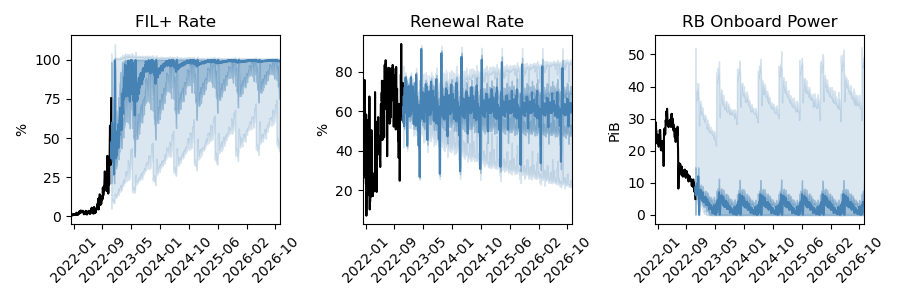

In [24]:
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

plt.figure(figsize=(9,3))
max_time = current_date + datetime.timedelta(days=365*4)

start_historical_time = np.max([t_rr[0].tz_convert(None), t_fpr[0], t_rbp[0]])
rr_ii = np.where(t_rr.values == start_historical_time)[0][0]
fpr_ii = np.where(t_fpr == start_historical_time)[0][0]
rbp_ii = np.where(t_rbp == start_historical_time)[0][0]

t_input = np.asarray([today + datetime.timedelta(days=x) for x in range(forecast_lenght)])
ii_intervention_start = (intervention_date - today).days
ii_intervention_vec_inputs = np.asarray([ii_intervention_start + x for x in range(360)])

# 'rb_onboard_power': np.median(np.asarray(rb_onboard_power_pred), axis=0), 
# 'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
# 'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0)

color = 'steelblue'
plt.subplot(1,3,1)
plt.plot(t_fpr[fpr_ii:], historical_fpr[fpr_ii:]*100, color='k')
plt.plot(t_input, np.quantile(np.asarray(filplus_rate_pred)*100, 0.5, axis=0), color=color)
plt.fill_between(t_input, np.quantile(np.asarray(filplus_rate_pred*100), 0.25, axis=0), np.quantile(np.asarray(filplus_rate_pred*100), 0.75, axis=0),
                color=color, alpha=0.4)
plt.fill_between(t_input, np.quantile(np.asarray(filplus_rate_pred*100), 0.05, axis=0), np.quantile(np.asarray(filplus_rate_pred*100), 0.95, axis=0),
                color=color, alpha=0.2)
# plt.plot(t_input[ii_intervention_vec_inputs], scenario_to_use['filplus_rate'][ii_intervention_vec_inputs])
plt.title('FIL+ Rate')
ax = plt.gca()
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(start_historical_time, max_time)
plt.xticks(rotation=45)
plt.ylabel('%')


plt.subplot(1,3,2)
# plt.plot(t_input, scenario_to_use['renewal_rate'])
plt.plot(t_rr[rr_ii:], historical_rr[rr_ii:]*100, color='k')
plt.plot(t_input, np.quantile(np.asarray(renewal_rate_pred*100), 0.5, axis=0), color=color)
plt.fill_between(t_input, np.quantile(np.asarray(renewal_rate_pred*100), 0.25, axis=0), np.quantile(np.asarray(renewal_rate_pred*100), 0.75, axis=0),
                color=color, alpha=0.4)
plt.fill_between(t_input, np.quantile(np.asarray(renewal_rate_pred*100), 0.05, axis=0), np.quantile(np.asarray(renewal_rate_pred*100), 0.95, axis=0),
                color=color, alpha=0.2)
plt.title('Renewal Rate')
ax = plt.gca()
plt.ylabel('%')

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(start_historical_time, max_time)
plt.xticks(rotation=45)

plt.subplot(1,3,3)
# plt.plot(t_input, scenario_to_use['rb_onboard_power'])
plt.plot(t_rbp[rbp_ii:], historical_rbp[rbp_ii:], color='k')
plt.plot(t_input, np.quantile(np.asarray(rb_onboard_power_pred), 0.5, axis=0), color=color)
plt.fill_between(t_input, np.quantile(np.asarray(rb_onboard_power_pred), 0.25, axis=0), np.quantile(np.asarray(rb_onboard_power_pred), 0.75, axis=0),
                color=color, alpha=0.4)
plt.fill_between(t_input, np.quantile(np.asarray(rb_onboard_power_pred), 0.05, axis=0), np.quantile(np.asarray(rb_onboard_power_pred), 0.95, axis=0),
                color=color, alpha=0.2)
plt.title('RB Onboard Power')
plt.ylabel('PiB')
ax = plt.gca()

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(start_historical_time, max_time)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'inputs.png'))